# Human bone marrow (ATAC-seq + protein)

In this tutorial we will guide you through your first data preprocessing and multimodal analysis of human bone marrow data using Ocelli.

Data comes from [Mimitou, Eleni P., et al. "Scalable, multimodal profiling of chromatin accessibility, gene expression and protein levels in single cells." Nature biotechnology 39.10 (2021): 1246-1258.](https://www.nature.com/articles/s41587-021-00927-2) and consists of two single-cell ASAP-seq modalities: ATAC-seq (chromatin accessibility) and protein. All analyses are performed on prefiltered data published by the authors on [GitHub](https://github.com/caleblareau/asap_reproducibility/tree/master/bonemarow_asapseq/output/for_total_vi_asap_marrow/filtered_feature_bc_matrix)

## Load the data

After downloading the data, the steps required for its loading hugely depend on its format. In this case, the count matrix is stored in the ``matrix.mtx`` file, which you can load as an AnnData object using scanpy. scanpy supports [multiple input data files](https://scanpy.readthedocs.io/en/stable/api.html#reading) for reading.

Next, transpose the count matrix so rows and columns correspond to cells and features. Ocelli strictly requires this count matrix orientation. Then, annotate cells (in ``adata.obs``) using ``barcodes.tsv`` and variable features (in ``adata.var``) using ``features.tsv`` files.

In [1]:
import scanpy as sc
from os.path import join
import pandas as pd

# path to downloaded files
data_folder = '../../../../data/human-bone-marrow'

adata = sc.read_mtx(join(data_folder, 'matrix.mtx'))

adata = adata.transpose()

df_obs = pd.read_csv(join(data_folder, 'barcodes.tsv'), sep='\t', header=None, index_col=0, names=['barcode'])
df_var = pd.read_csv(join(data_folder, 'features.tsv'), sep='\t', header=None, index_col=1, names=['gene', 'modality'])[['modality']]

adata.obs = df_obs
adata.obs_names_make_unique()

adata.var = df_var
adata.var_names_make_unique()

adata

AnnData object with n_obs × n_vars = 10927 × 3238
    var: 'modality'

In [2]:
adata.obs

""
barcode
AAACGAAAGCGTATCT-1
AAACGAAAGCGTTGCC-1
AAACGAAAGGATTGAT-1
AAACGAAAGGCGTCCT-1
AAACGAAAGTCGTGAG-1
...
TTTGTGTGTTCCATCC-1
TTTGTGTGTTGGCGAA-1
TTTGTGTTCACGTGTA-1


In [3]:
adata.var

,modality
GNB1,Gene Expression
PRKCZ,Gene Expression
SKI,Gene Expression
C1orf174,Gene Expression
KCNAB2,Gene Expression
...,...
CD151,Antibody Capture
CD183,Antibody Capture
CD37,Antibody Capture
CD33,Antibody Capture


The dataset consists of 10927 cells and 3238 features, which belong to two modalities based on ``adata.var['modality']``. Modalities are usually stored in separate files, but we will have to split features manually in this case.

Each modality's count matrix comes from a different distribution, and you should preprocess them individually. We recommend creating a separate AnnData object for each modality for preprocessing steps.

ATAC-seq count matrix has 3000 preselected genes.

In [4]:
chromatin = adata[:, adata.var['modality'] == 'Gene Expression']
chromatin

View of AnnData object with n_obs × n_vars = 10927 × 3000
    var: 'modality'

Protein count matrix has 238 proteins.

In [5]:
protein = adata[:, adata.var['modality'] == 'Antibody Capture']
protein

View of AnnData object with n_obs × n_vars = 10927 × 238
    var: 'modality'

Off to preprocessing!

## Topic modeling

Import Ocelli and set seed for reproducible results.

In [6]:
import ocelli as oci

SEED = 17

Topic modeling is a crucial step of Ocelli data preprocessing. Latent Dirichlet Allocation is a generative probabilistic topic model which groups features into cohesive groups (topics). One of its outputs is a probability distribution of how probable it is that a cell belongs to a specific topic based on its features. These latent representations are highly-compressed and information-rich data embeddings on which we train models.

It would be best if you ran topic modeling on raw count matrices without normalization. However, feel free to filter low-quality cells/features beforehand. In this case, data is preprepared by the authors, so you can leave it as it is.

Calculate ATAC-seq topics. ``n_components`` defines the number of topics. Below we will show you how to examine whether the selected number of topics is good or could be tweaked. LDA is a probabilistic model and should converge after several iterations that you can control using the ``max_iter`` parameter. Higher ``max_iter`` results in longer training times and a higher probability of a converged model.

In [7]:
oci.pp.LDA(chromatin, n_components=15, verbose=1, max_iter=50, random_state=SEED)

iteration: 1 of max_iter: 50
iteration: 2 of max_iter: 50
iteration: 3 of max_iter: 50
iteration: 4 of max_iter: 50
iteration: 5 of max_iter: 50
iteration: 6 of max_iter: 50
iteration: 7 of max_iter: 50
iteration: 8 of max_iter: 50
iteration: 9 of max_iter: 50
iteration: 10 of max_iter: 50
iteration: 11 of max_iter: 50
iteration: 12 of max_iter: 50
iteration: 13 of max_iter: 50
iteration: 14 of max_iter: 50
iteration: 15 of max_iter: 50
iteration: 16 of max_iter: 50
iteration: 17 of max_iter: 50
iteration: 18 of max_iter: 50
iteration: 19 of max_iter: 50
iteration: 20 of max_iter: 50
iteration: 21 of max_iter: 50
iteration: 22 of max_iter: 50
iteration: 23 of max_iter: 50
iteration: 24 of max_iter: 50
iteration: 25 of max_iter: 50
iteration: 26 of max_iter: 50
iteration: 27 of max_iter: 50
iteration: 28 of max_iter: 50
iteration: 29 of max_iter: 50
iteration: 30 of max_iter: 50
iteration: 31 of max_iter: 50
iteration: 32 of max_iter: 50
iteration: 33 of max_iter: 50
iteration: 34 of ma

Distributions of topics for each cell are saved in ``adata.obsm['lda']`` in an array of shape ``(n_obs, n_topics)`` - on this representation, we will train models. Also, variational parameters for feature-gene distribution are saved in ``adata.varm['lda']`` in an array of shape ``(n_var, n_topics)``.

In [8]:
chromatin

AnnData object with n_obs × n_vars = 10927 × 3000
    var: 'modality'
    uns: 'lda_params'
    obsm: 'lda'
    varm: 'lda'

Similarly, calculate protein topics.

In [9]:
oci.pp.LDA(protein, n_components=15, verbose=1, max_iter=50, random_state=SEED)

iteration: 1 of max_iter: 50
iteration: 2 of max_iter: 50
iteration: 3 of max_iter: 50
iteration: 4 of max_iter: 50
iteration: 5 of max_iter: 50
iteration: 6 of max_iter: 50
iteration: 7 of max_iter: 50
iteration: 8 of max_iter: 50
iteration: 9 of max_iter: 50
iteration: 10 of max_iter: 50
iteration: 11 of max_iter: 50
iteration: 12 of max_iter: 50
iteration: 13 of max_iter: 50
iteration: 14 of max_iter: 50
iteration: 15 of max_iter: 50
iteration: 16 of max_iter: 50
iteration: 17 of max_iter: 50
iteration: 18 of max_iter: 50
iteration: 19 of max_iter: 50
iteration: 20 of max_iter: 50
iteration: 21 of max_iter: 50
iteration: 22 of max_iter: 50
iteration: 23 of max_iter: 50
iteration: 24 of max_iter: 50
iteration: 25 of max_iter: 50
iteration: 26 of max_iter: 50
iteration: 27 of max_iter: 50
iteration: 28 of max_iter: 50
iteration: 29 of max_iter: 50
iteration: 30 of max_iter: 50
iteration: 31 of max_iter: 50
iteration: 32 of max_iter: 50
iteration: 33 of max_iter: 50
iteration: 34 of ma

While we did not normalize data for topic modeling, all further analyses require normalized data. Thankfully, LDA cell-topic distributions need no further normalization, as they are cell-normalized by design (topic probabilities sum to 1 for each cell).

In [10]:
chromatin.obsm['lda'].sum(axis=1)

array([1., 1., 1., ..., 1., 1., 1.])

In [11]:
protein.obsm['lda'].sum(axis=1)

array([1., 1., 1., ..., 1., 1., 1.])

As a result, both modalities are preprocessed. You need to prepare it for training Multimodal Diffusion Maps. You need to:

- Create a new AnnData object ``adata`` with as many rows as there are cells*, a number of columns can be any positive number,
- Save cell metadata to ``adata.obs``,
- Save preprocessed modality matrices to ``adata.obsm``,
- Save a list of modality ``adata.obsm`` keys to ``adata.uns['modalities']``.

*You can achieve it quickly by initiating AnnData with an empty ``scipy.sparse.csr_matrix`` - below is an example!

In [12]:
import numpy as np
from scipy.sparse import csr_matrix
import anndata

n_cells = adata.shape[0]

# csr_matrix takes matrix shape as an input
dummy_csr = csr_matrix((n_cells, 1))

adata = anndata.AnnData(dummy_csr)

adata.obs = df_obs

adata.obsm['chromatin'] = chromatin.obsm['lda']
adata.obsm['protein'] = protein.obsm['lda']

adata.uns['modalities'] = ['chromatin', 'protein']

adata

AnnData object with n_obs × n_vars = 10927 × 1
    uns: 'modalities'
    obsm: 'chromatin', 'protein'

Data is ready for training!

## Multimodal Diffusion Maps

To create multimodal visualizations of human bone marrow cells, you need to create a multimodal embedding that combines information from both modalities. Repeat the three-stage process from the **Getting Started** tutorial:

- Nearest neighbors search,
- Calculation of multimodal weights,
- Calculation of Multimodal Diffusion Maps embedding.

In [13]:
oci.pp.neighbors(adata, n_neighbors=50, verbose=True)
oci.tl.weights(adata, random_state=SEED, verbose=True)
oci.tl.MDM(adata, n_components=10, random_state=SEED, verbose=True)

[chromatin] 50 nearest neighbors calculated.
[protein] 50 nearest neighbors calculated.


2022-10-12 22:08:08,333	INFO worker.py:1518 -- Started a local Ray instance.


Multimodal cell-specific weights estimated.


2022-10-12 22:08:14,834	INFO worker.py:1518 -- Started a local Ray instance.


[chromatin] Unimodal Markov chain calculated
[protein] Unimodal Markov chain calculated
Multimodal Markov chain calculated
Eigendecomposition finished.
10 Multimodal Diffusion Maps components calculated.


For this dataset, ten components are sufficient to capture well the global structure.

## Visualizations

In [14]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

Ocelli has wrappers for two tools suitable for further dimension reduction to 2 or 3 dimensions that can be visualized: ForceAtlas2 and UMAP. ForceAtlas2 is very potent for well-connected datasets with complex substructures. UMAP works better for data with different clusters. Here, we recommend UMAP.

(<Figure size 960x720 with 1 Axes>, <AxesSubplot:>)

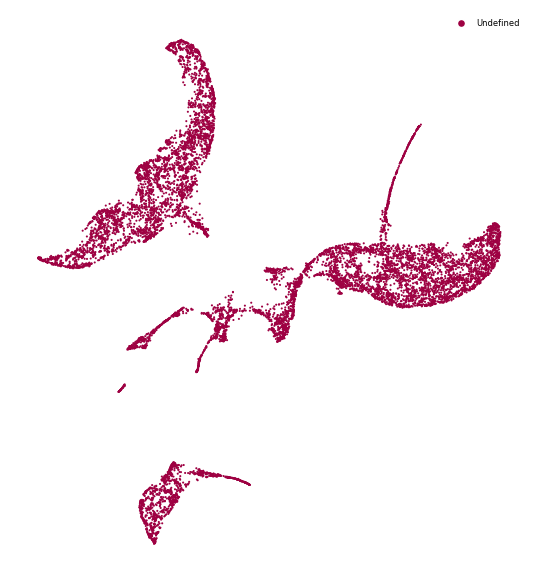

In [15]:
oci.tl.UMAP(adata, obsm_key='X_mdm', n_neighbors=100, min_dist=0.1, random_state=SEED)
oci.pl.scatter(adata, x_key='X_umap', marker_size=1)

You can easily change scatter plot colors - using matplotlib colormap objects or [predefined colormap names](https://matplotlib.org/stable/tutorials/colors/colormaps.html) - and color schemes - using aby ``adata.obs`` columns.

Below, a new colormap is defined using ``matplotlib.colors``. You can use it for visualizing weight distributions for each modality.

(<Figure size 960x720 with 2 Axes>, <AxesSubplot:>)

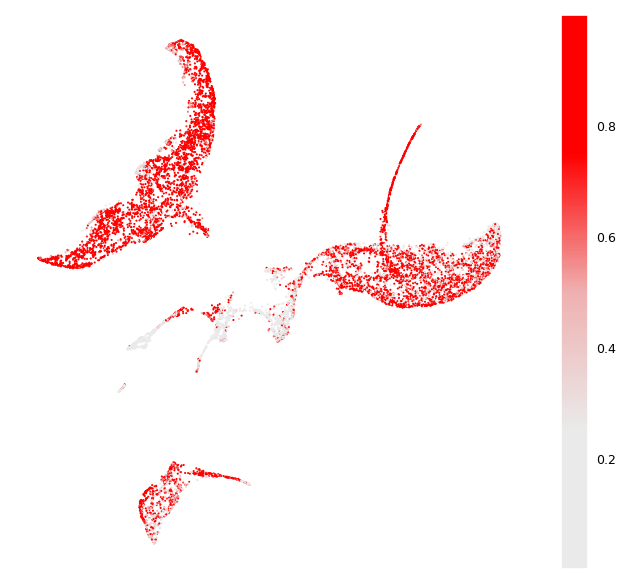

In [16]:
weights_cmap = mpl.colors.LinearSegmentedColormap.from_list('custom', ['#EAEAEA', '#EAEAEA', '#EFB0B0', '#FF0000', '#FF0000'], N=256)

adata.obs['w_protein'] = list(adata.obsm['weights']['protein'])
oci.pl.scatter(adata, x_key='X_umap', color_key='w_protein', cmap=weights_cmap, marker_size=1)

(<Figure size 960x720 with 2 Axes>, <AxesSubplot:>)

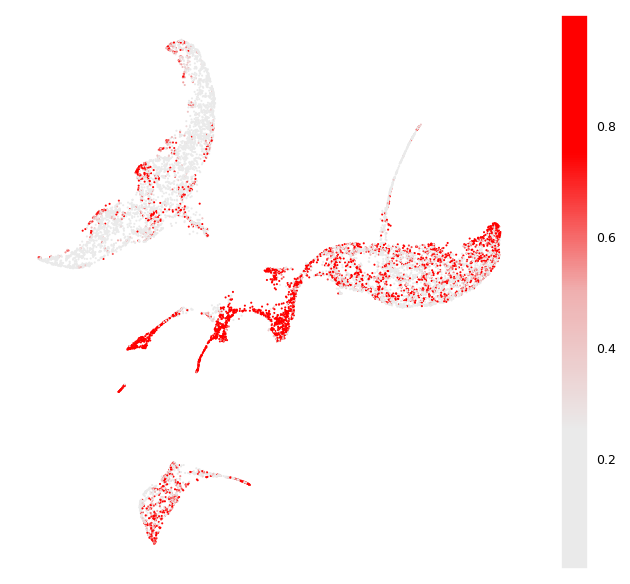

In [17]:
adata.obs['w_chromatin'] = list(adata.obsm['weights']['chromatin'])
oci.pl.scatter(adata, x_key='X_umap', color_key='w_chromatin', cmap=weights_cmap, marker_size=1)

You can see that there are three major clusters. But what are they? This question can often be answered using maker analysis. 

Below you can see how to analyze marker activity using Ocelli. To do so, we need to go back to raw count matrices and normalize and logarithmize them. Preprocessed counts can be used for calculating z-scores for each cell for a given marker signature (a set of markers). Z-scores are then averaged over specified markers. However, here we show z-scores calculated for single protein markers, not collections of markers.

In [18]:
sc.pp.normalize_total(protein, target_sum=10000)
sc.pp.log1p(protein)

For example, the CD14 protein marker is expressed in monocytes.

2022-10-12 22:09:17,122	INFO worker.py:1518 -- Started a local Ray instance.


(<Figure size 960x720 with 2 Axes>, <AxesSubplot:>)

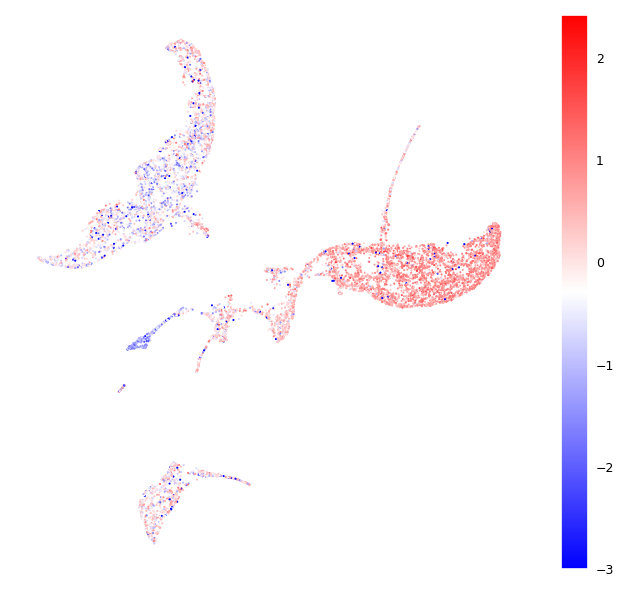

In [19]:
protein_marker =  'CD14'

index_of_marker_column = list(protein.var.index).index(protein_marker) #find index of marker in adata.var.index
oci.tl.mean_z_scores(protein, markers=[index_of_marker_column], output_key=protein_marker)

adata.obs[protein_marker] = list(protein.obs[protein_marker])
oci.pl.scatter(adata, x_key='X_umap', color_key=protein_marker, cmap='bwr', marker_size=1)

The CD71 protein marker is expressed in progenitor and erythroid cells.

(<Figure size 960x720 with 2 Axes>, <AxesSubplot:>)

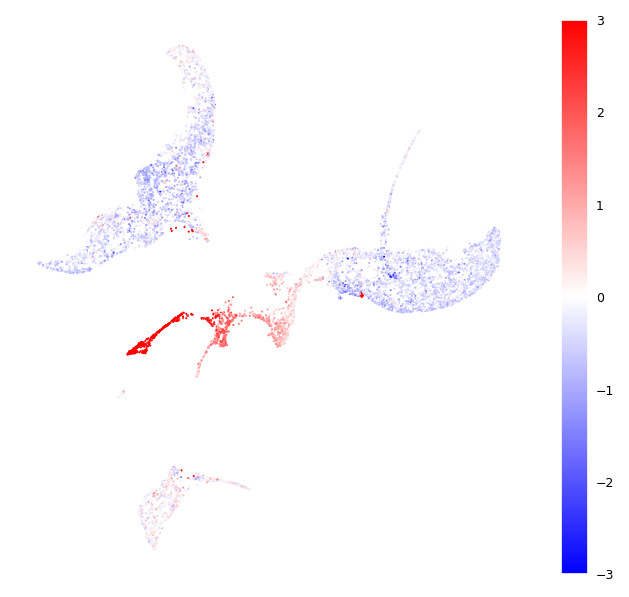

In [20]:
protein_marker =  'CD71'

index_of_marker_column = list(protein.var.index).index(protein_marker) #find index of marker in adata.var.index
oci.tl.mean_z_scores(protein, markers=[index_of_marker_column], output_key=protein_marker)

adata.obs[protein_marker] = list(protein.obs[protein_marker])
oci.pl.scatter(adata, x_key='X_umap', color_key=protein_marker, cmap='bwr', marker_size=1)

The CD19 protein marker is expressed in B cells.

(<Figure size 960x720 with 2 Axes>, <AxesSubplot:>)

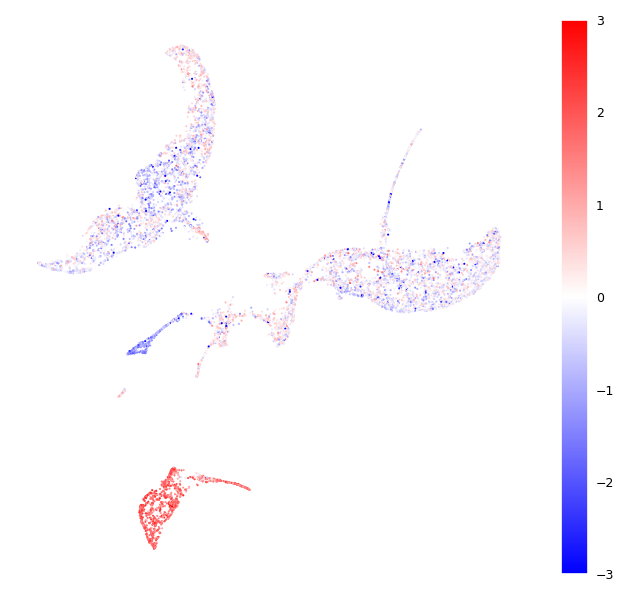

In [21]:
protein_marker =  'CD19'

index_of_marker_column = list(protein.var.index).index(protein_marker) #find index of marker in adata.var.index
oci.tl.mean_z_scores(protein, markers=[index_of_marker_column], output_key=protein_marker)

adata.obs[protein_marker] = list(protein.obs[protein_marker])
oci.pl.scatter(adata, x_key='X_umap', color_key=protein_marker, cmap='bwr', marker_size=1)

The CD3 protein marker is expressed in T cells.

(<Figure size 960x720 with 2 Axes>, <AxesSubplot:>)

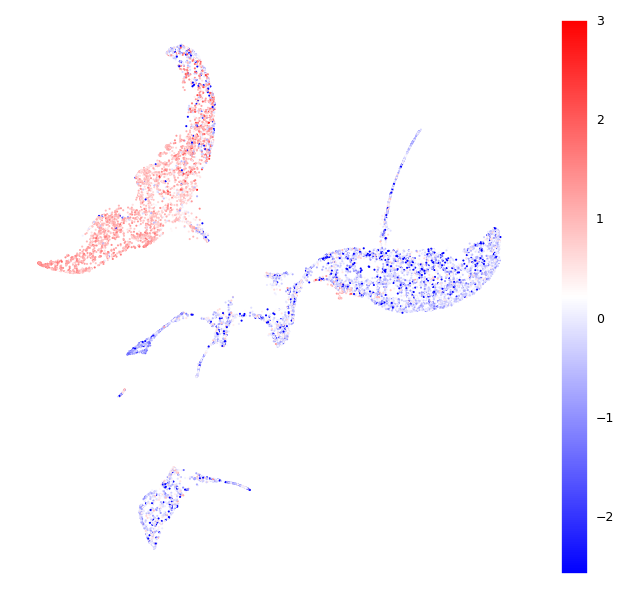

In [22]:
protein_marker =  'CD3-1'

index_of_marker_column = list(protein.var.index).index(protein_marker) #find index of marker in adata.var.index
oci.tl.mean_z_scores(protein, markers=[index_of_marker_column], output_key=protein_marker)

adata.obs[protein_marker] = list(protein.obs[protein_marker])
oci.pl.scatter(adata, x_key='X_umap', color_key=protein_marker, cmap='bwr', marker_size=1)

(<Figure size 960x720 with 2 Axes>, <AxesSubplot:>)

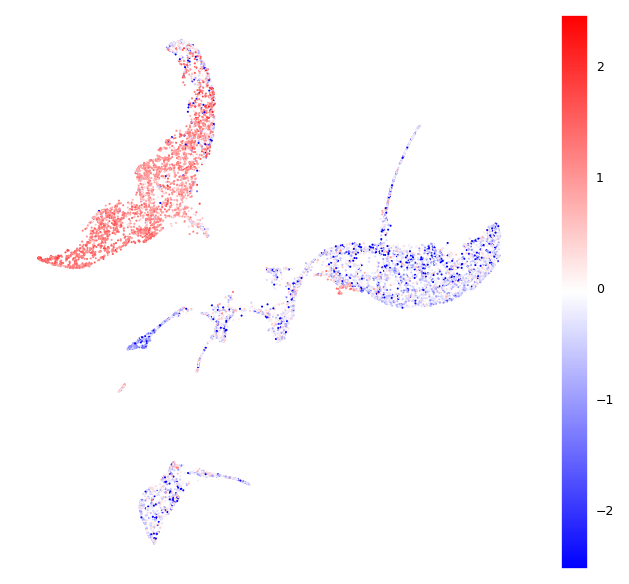

In [23]:
protein_marker =  'CD3-2'

index_of_marker_column = list(protein.var.index).index(protein_marker) #find index of marker in adata.var.index
oci.tl.mean_z_scores(protein, markers=[index_of_marker_column], output_key=protein_marker)

adata.obs[protein_marker] = list(protein.obs[protein_marker])
oci.pl.scatter(adata, x_key='X_umap', color_key=protein_marker, cmap='bwr', marker_size=1)

Marker analysis gives a much better look at the structure of the data. It provides an interesting understanding of what multimodal weights learned. DNA weights are most dominant around progenitor cells, while protein weights are active for B cells, T cells, and monocytes.

Now, let's go back for a second to selecting ``n_components`` for topic modeling. There is no rigorous recipe, but we suggest experimenting with different values and plotting cells' topic distributions. Increase the number of topics until you start seeing noisy topics (no strong, region-specific signals).

Here you can see ATAC-seq's topic distributions used for this analysis.

(<Figure size 960x720 with 16 Axes>,
 array([[<AxesSubplot:title={'center':'0'}>,
         <AxesSubplot:title={'center':'1'}>,
         <AxesSubplot:title={'center':'2'}>,
         <AxesSubplot:title={'center':'3'}>,
         <AxesSubplot:title={'center':'4'}>],
        [<AxesSubplot:title={'center':'5'}>,
         <AxesSubplot:title={'center':'6'}>,
         <AxesSubplot:title={'center':'7'}>,
         <AxesSubplot:title={'center':'8'}>,
         <AxesSubplot:title={'center':'9'}>],
        [<AxesSubplot:title={'center':'10'}>,
         <AxesSubplot:title={'center':'11'}>,
         <AxesSubplot:title={'center':'12'}>,
         <AxesSubplot:title={'center':'13'}>,
         <AxesSubplot:title={'center':'14'}>]], dtype=object))

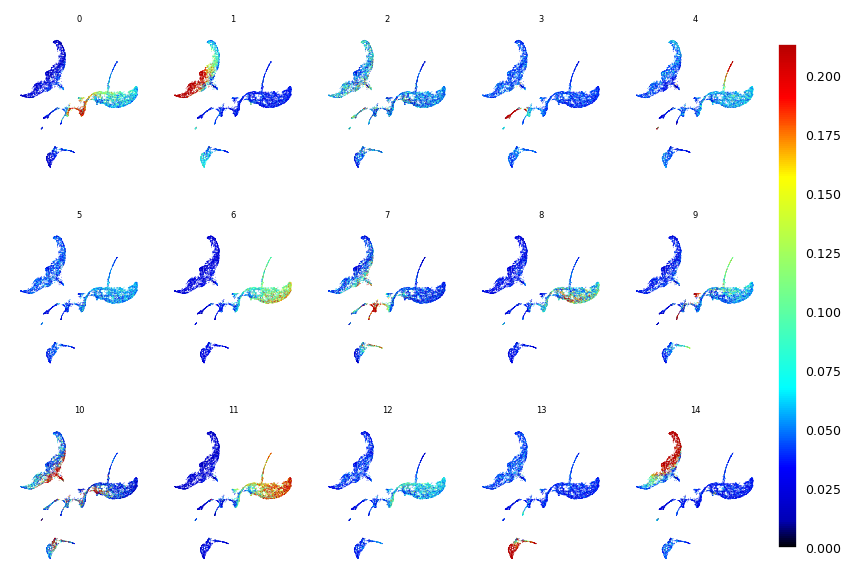

In [24]:
oci.pl.topics(adata, x_key='X_umap', topics_key='chromatin', marker_size=0.1)

And the same plot for protein topics.

(<Figure size 960x720 with 16 Axes>,
 array([[<AxesSubplot:title={'center':'0'}>,
         <AxesSubplot:title={'center':'1'}>,
         <AxesSubplot:title={'center':'2'}>,
         <AxesSubplot:title={'center':'3'}>,
         <AxesSubplot:title={'center':'4'}>],
        [<AxesSubplot:title={'center':'5'}>,
         <AxesSubplot:title={'center':'6'}>,
         <AxesSubplot:title={'center':'7'}>,
         <AxesSubplot:title={'center':'8'}>,
         <AxesSubplot:title={'center':'9'}>],
        [<AxesSubplot:title={'center':'10'}>,
         <AxesSubplot:title={'center':'11'}>,
         <AxesSubplot:title={'center':'12'}>,
         <AxesSubplot:title={'center':'13'}>,
         <AxesSubplot:title={'center':'14'}>]], dtype=object))

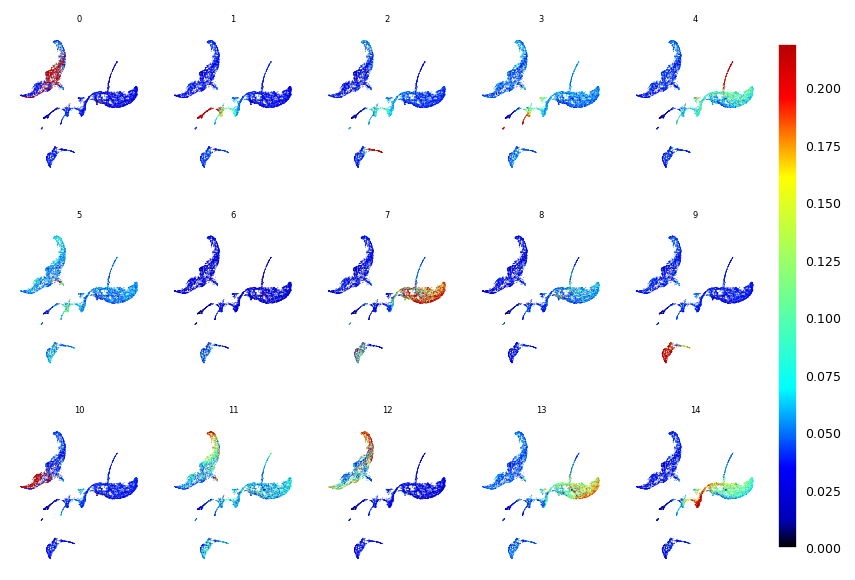

In [25]:
oci.pl.topics(adata, x_key='X_umap', topics_key='protein', marker_size=0.1)